In [1]:
from pymongo import MongoClient
from bson.objectid import ObjectId

import time,datetime
import os

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style

from copy import deepcopy
from IPython.display import clear_output

In [2]:
conn = MongoClient('120.126.136.17')
db = conn.Tracker
collection = [db.james]# db.db2, db.dn2, db.james, db.leo
clean_data = []
for col in collection:
    cursor = col.find({})
    df = pd.DataFrame(list(cursor))
df['step_value'].replace('', 0, inplace=True)
df.replace('', np.nan, inplace=True)
df.fillna(method='ffill', inplace=True)

df['hr_value'] = df['hr_value'].astype(float)
df['o2_value'] = df['o2_value'].astype(float)
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)
df['step_value'] = df['step_value'].astype(float)

# map out the weekday
df['weekday'] = df['timestamp'].apply(lambda x: int(datetime.datetime.fromtimestamp(x).strftime('%w')))
df['week'] = df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).isocalendar()[1]
          - (datetime.datetime.fromtimestamp(x).isoweekday() < 7)) # do this so that week may start on monday

In [3]:
dfstephour = pd.DataFrame({})
dfstephour = df[['week', 'weekday']].set_index(['week', 'weekday'])
dfstephour = dfstephour[~dfstephour.index.duplicated(keep='first')]
earlestweek = df['week'].values[0]
latestweek = df['week'].values[-1]
addindex = pd.DataFrame({})
for i in range(earlestweek, latestweek):
    for j in range(7):
        if not (i,j) in dfstephour.index:
            add = pd.DataFrame({'week':[i],'weekday':[j]})
            addindex = addindex.append(add)
dfstephour.reset_index(inplace=True)
dfstephour = dfstephour.append(addindex)
dfstephour = dfstephour.set_index(['week', 'weekday'])
dfstephour = dfstephour.sort_index()
for i in range(24):
    dfstephour[i] = 0

# here I map between integer and the sting it's mean
timeslidemap = {0:'msteps', 1:'asteps', 2:'esteps'}
basestamp = df['timestamp'][0]
endstamp = df['timestamp'][-1:].values[0]
# for num, row in df[:30000].iterrows():
while True:
    try:
        hour = datetime.datetime.fromtimestamp(basestamp).hour
        dfbetween = df.loc[df['timestamp'].between(
            datetime.datetime.fromtimestamp(basestamp).replace(hour=hour,minute=0,second=0).timestamp(),
            datetime.datetime.fromtimestamp(basestamp).replace(hour=hour,minute=59,second=59).timestamp()
                    , inclusive=True)]
        steps = dfbetween['step_value'].sum()
    #     print(int(datetime.datetime.fromtimestamp(basestamp).strftime('%m')),
    #             int(datetime.datetime.fromtimestamp(basestamp).strftime('%d')),
    #                 timeslidemap[estimedevide])

        dfstephour.loc[[(datetime.datetime.fromtimestamp(basestamp).isocalendar()[1] - 
                                    (datetime.datetime.fromtimestamp(basestamp).isoweekday() < 7),
                            int(datetime.datetime.fromtimestamp(basestamp).strftime('%w')))], 
                                           [hour]] += steps

        basestamp = (datetime.datetime.fromtimestamp(basestamp) + datetime.timedelta(hours=1)).timestamp()
        if basestamp > endstamp:
            break
    except Exception as e:
#         print(str(e))
        basestamp = (datetime.datetime.fromtimestamp(basestamp) + datetime.timedelta(hours=1)).timestamp()
#     else:
#         print(datetime.datetime.fromtimestamp(basestamp) ,datetime.datetime.fromtimestamp(endstamp))
steps = dfstephour.values
train_X = []
for weekday,i in enumerate(steps):
    for hour,j in enumerate(i):
        add = np.array([j])#[weekday, hour, j]
        train_X.append(add)
# the ending of training data is the  hour of now 
train_X = train_X[:-(24-datetime.datetime.now().time().hour + 1)]
train_X = np.array(train_X)

In [4]:
# dfseries = pd.DataFrame({})
# for i in range(13,21):
#     dfseries = pd.concat(dfseries,dfstephour.loc[i,'1'][8:10])

# # dfstephour.loc[20,'1'][9]

dftempt = dfstephour.drop([0,1,2,3,4,5,6,7,11,12,13,14,15,16,17,18,19,20,21,22,23],axis=1)
for i in range(12,20):
    for j in [0,2,3,4,5,6]:
        dftempt = dftempt.drop([(i,j)])
dftempt
for j in [0,2,3,4,5]:
    dftempt = dftempt.drop([(20,j)])
dftempt = dftempt.drop([(12,1)])
dftempt = dftempt.drop([(17,1)])
dftempt = dftempt.drop([(14,1)])
print(dftempt.mean())
dftempt

8     2227.000000
9     2440.000000
10    1233.166667
dtype: float64


,,8,9,10
week,weekday,,,
13,1,1962.0,2320.0,742.0
15,1,1935.0,3030.0,1997.0
16,1,2643.0,2400.0,1762.0
18,1,1998.0,2924.0,0.0
19,1,2724.0,2468.0,1500.0
20,1,2100.0,1498.0,1398.0


In [6]:
lis = []
for i in range(12,20):
    for j in range(7):    
        for s in range(24):
            if dfstephour.loc[(i,j)][s] == 0:
                lis.append([(i,j), s])
lis

[[(12, 0), 0],
 [(12, 0), 1],
 [(12, 0), 2],
 [(12, 0), 3],
 [(12, 0), 4],
 [(12, 0), 5],
 [(12, 0), 6],
 [(12, 0), 7],
 [(12, 0), 8],
 [(12, 0), 9],
 [(12, 0), 10],
 [(12, 0), 11],
 [(12, 0), 12],
 [(12, 0), 13],
 [(12, 0), 14],
 [(12, 0), 15],
 [(12, 0), 16],
 [(12, 0), 17],
 [(12, 0), 18],
 [(12, 0), 19],
 [(12, 0), 20],
 [(12, 0), 21],
 [(12, 0), 22],
 [(12, 0), 23],
 [(12, 1), 0],
 [(12, 1), 1],
 [(12, 1), 2],
 [(12, 1), 3],
 [(12, 1), 4],
 [(12, 1), 5],
 [(12, 1), 6],
 [(12, 1), 7],
 [(12, 1), 8],
 [(12, 1), 9],
 [(12, 1), 10],
 [(12, 1), 11],
 [(12, 1), 12],
 [(12, 1), 13],
 [(12, 1), 14],
 [(12, 1), 15],
 [(12, 1), 16],
 [(12, 1), 17],
 [(12, 1), 18],
 [(12, 1), 19],
 [(12, 1), 20],
 [(12, 1), 21],
 [(12, 1), 22],
 [(12, 1), 23],
 [(12, 2), 0],
 [(12, 2), 1],
 [(12, 2), 2],
 [(12, 2), 3],
 [(12, 2), 4],
 [(12, 2), 5],
 [(12, 2), 6],
 [(12, 2), 7],
 [(12, 2), 8],
 [(12, 2), 9],
 [(12, 2), 10],
 [(12, 2), 11],
 [(12, 2), 12],
 [(12, 2), 13],
 [(12, 2), 14],
 [(12, 2), 15],
 [(12,

In [9]:
lis = []
for i in range(12,20):
    for j in range(7):    
        for s in range(24):
            if dfstephour.loc[(i,j)][s] > 1900:
                lis.append([(i,j), s])

[(12, 3), 17]
            step_value  hr_value
step_value    1.000000  0.221705
hr_value      0.221705  1.000000


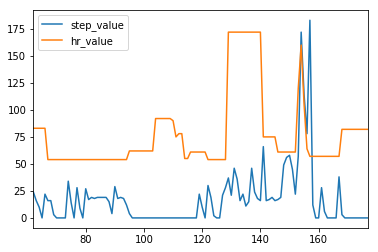

[(13, 1), 8]
            step_value  hr_value
step_value    1.000000 -0.008646
hr_value     -0.008646  1.000000


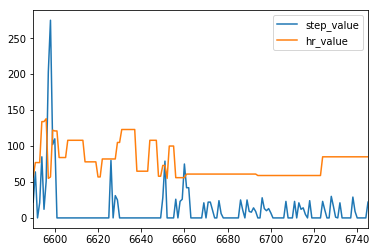

[(13, 1), 9]
            step_value  hr_value
step_value    1.000000 -0.273933
hr_value     -0.273933  1.000000


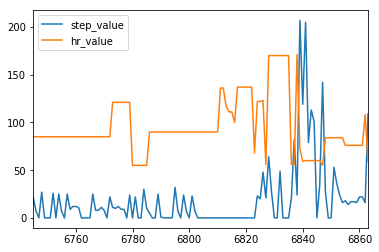

[(13, 1), 11]
            step_value  hr_value
step_value    1.000000 -0.115181
hr_value     -0.115181  1.000000


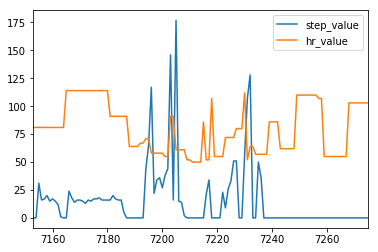

[(13, 3), 20]
            step_value  hr_value
step_value    1.000000  0.284367
hr_value      0.284367  1.000000


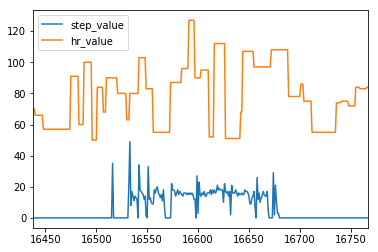

[(14, 0), 17]
            step_value  hr_value
step_value    1.000000  0.187472
hr_value      0.187472  1.000000


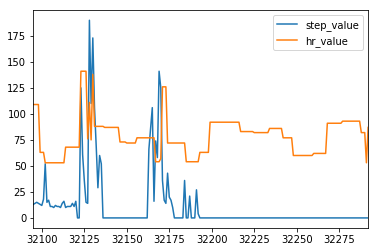

[(14, 0), 20]
            step_value  hr_value
step_value    1.000000 -0.422869
hr_value     -0.422869  1.000000


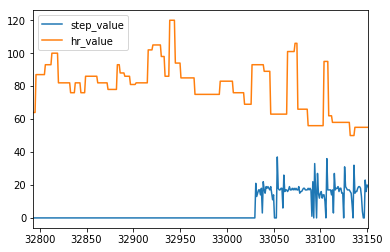

[(15, 1), 8]
            step_value  hr_value
step_value    1.000000 -0.069469
hr_value     -0.069469  1.000000


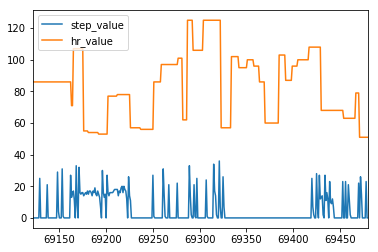

[(15, 1), 9]
            step_value  hr_value
step_value     1.00000   0.03539
hr_value       0.03539   1.00000


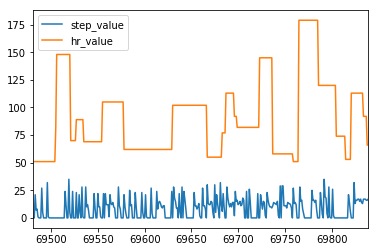

[(15, 1), 10]
            step_value  hr_value
step_value     1.00000   0.08254
hr_value       0.08254   1.00000


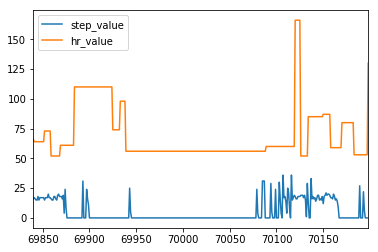

[(15, 2), 20]
            step_value  hr_value
step_value    1.000000 -0.042688
hr_value     -0.042688  1.000000


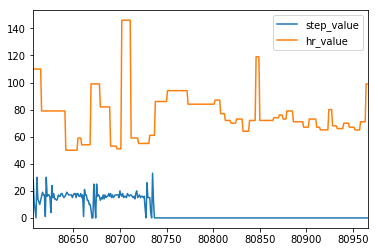

[(16, 1), 8]
            step_value  hr_value
step_value    1.000000  0.205975
hr_value      0.205975  1.000000


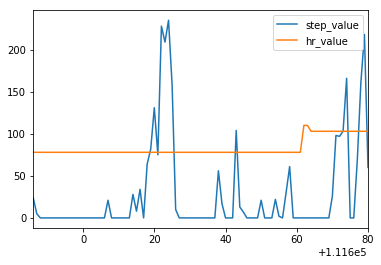

[(16, 1), 9]
            step_value  hr_value
step_value    1.000000  0.507762
hr_value      0.507762  1.000000


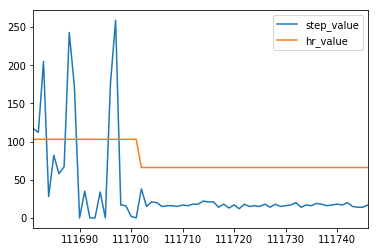

[(16, 1), 12]
            step_value  hr_value
step_value    1.000000 -0.100811
hr_value     -0.100811  1.000000


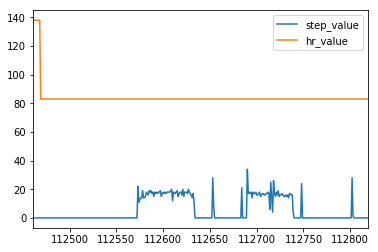

[(16, 2), 21]
            step_value  hr_value
step_value    1.000000  0.371966
hr_value      0.371966  1.000000


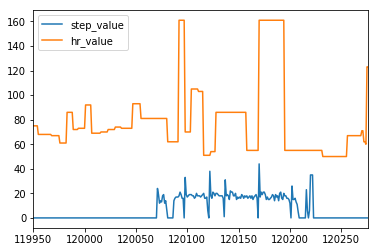

[(16, 3), 12]
            step_value  hr_value
step_value    1.000000 -0.075072
hr_value     -0.075072  1.000000


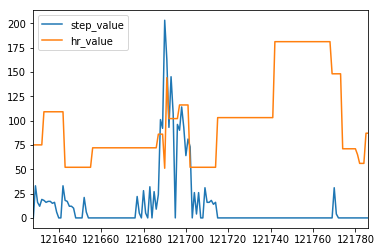

[(16, 5), 9]
            step_value  hr_value
step_value    1.000000  0.290156
hr_value      0.290156  1.000000


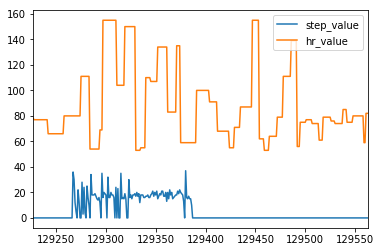

[(17, 0), 20]
            step_value  hr_value
step_value    1.000000  0.628619
hr_value      0.628619  1.000000


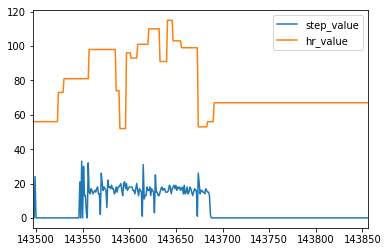

[(17, 1), 17]
            step_value  hr_value
step_value    1.000000  0.114056
hr_value      0.114056  1.000000


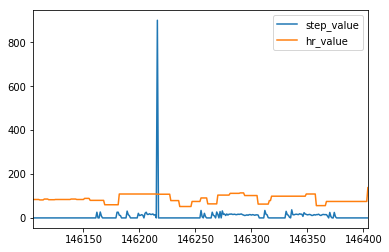

[(17, 1), 21]
            step_value  hr_value
step_value    1.000000 -0.212038
hr_value     -0.212038  1.000000


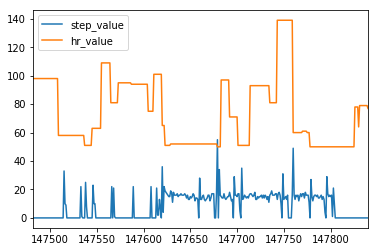

[(17, 2), 12]
            step_value  hr_value
step_value    1.000000 -0.333191
hr_value     -0.333191  1.000000


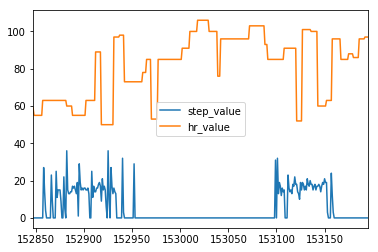

[(18, 0), 11]
            step_value  hr_value
step_value     1.00000   0.08495
hr_value       0.08495   1.00000


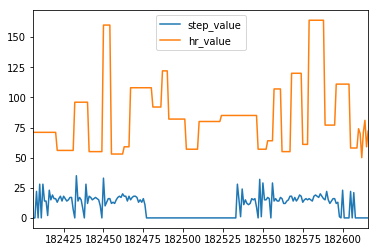

[(18, 1), 8]
            step_value  hr_value
step_value    1.000000  0.268069
hr_value      0.268069  1.000000


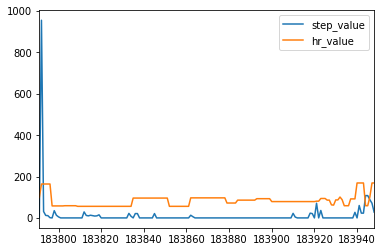

[(18, 1), 9]
            step_value  hr_value
step_value     1.00000   0.17025
hr_value       0.17025   1.00000


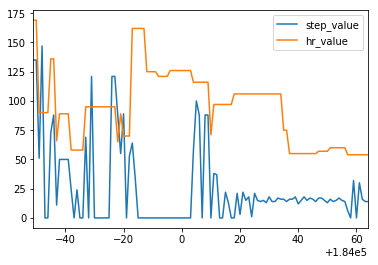

[(18, 6), 16]
            step_value  hr_value
step_value    1.000000 -0.151985
hr_value     -0.151985  1.000000


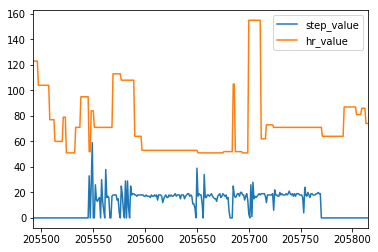

[(19, 1), 8]
            step_value  hr_value
step_value    1.000000 -0.342672
hr_value     -0.342672  1.000000


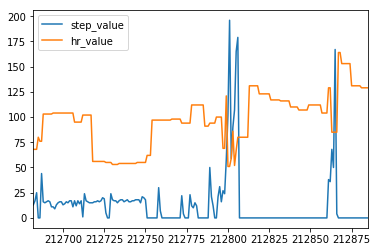

[(19, 1), 9]
            step_value  hr_value
step_value     1.00000  -0.24444
hr_value      -0.24444   1.00000


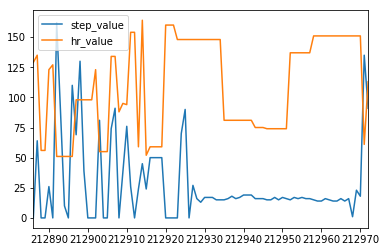

[(19, 2), 16]
            step_value  hr_value
step_value    1.000000 -0.119285
hr_value     -0.119285  1.000000


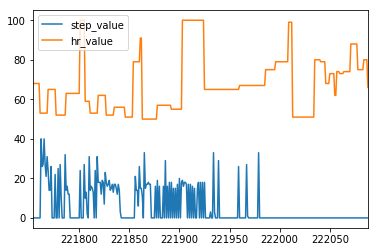

[(19, 2), 18]
            step_value  hr_value
step_value    1.000000  0.015976
hr_value      0.015976  1.000000


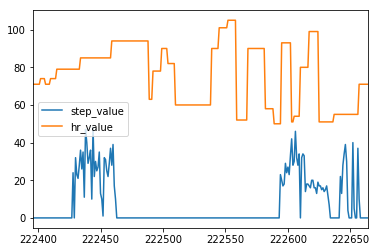

[(19, 4), 9]
            step_value  hr_value
step_value    1.000000 -0.095755
hr_value     -0.095755  1.000000


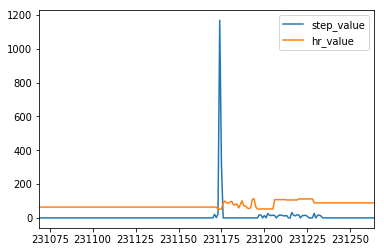

[(19, 5), 18]
            step_value  hr_value
step_value     1.00000  -0.02315
hr_value      -0.02315   1.00000


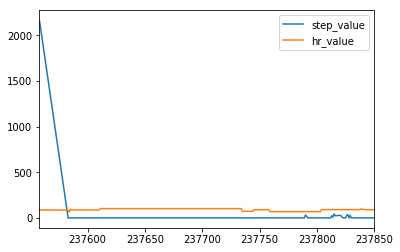

In [51]:
%matplotlib inline
for i in lis:
    print(i)
    dfbetween = df.loc[df['timestamp'].between(
            (datetime.datetime(2019,3,24) + datetime.timedelta(days = 7*(i[0][0] - 12) + i[0][1]) + 
                 datetime.timedelta(hours=i[1])).timestamp(),
            (datetime.datetime(2019,3,24) + datetime.timedelta(days = 7*(i[0][0] - 12) + i[0][1]) + 
                 datetime.timedelta(hours=i[1] + 1)).timestamp()
                    , inclusive=True)]
    dfbetween[['step_value','hr_value']].plot()
    print(dfbetween[['step_value','hr_value']].corr())
    plt.show()

In [39]:
collection = [db.prediction]
for col in collection:
    cursor = col.find({})
    df_prediction = pd.DataFrame(list(cursor))

In [18]:
start = datetime.datetime(year = 2019, month = 5, day = 2, hour=15).timestamp()
end = datetime.datetime(year = 2019, month = 5, day = 2, hour=16).timestamp()
df.loc[(df['timestamp'] < end) & (df['timestamp'] > start),['step_value']].sum()

step_value    921.0
dtype: float64

In [21]:
# df_prediction = df_prediction[4:]
df_prediction[''] = df.loc[(df['timestamp'] < datetime.datetime( 
    year = df_prediction['year'],month = df_prediction['month'], day = df_prediction['month'], hour=df_prediction['hour']).timestamp()) & 
    (df['timestamp'] > datetime.datetime( 
    year = df_prediction['year'],month = df_prediction['month'], day = df_prediction['month'], hour=df_prediction['hour'] + 1).timestamp()),['step_value']].sum()

TypeError: cannot convert the series to <class 'int'>

In [77]:
df_pre = pd.DataFrame({})
for index, rows in df_prediction.iterrows():
    if rows['type'] == 'hourly':
        start = datetime.datetime( 
        year = rows['year'],month = rows['month'], day = rows['day'], hour=int(rows['hour'])).timestamp()
        end = start + 60*60
#         print(df.loc[(df['timestamp'] < end) & (df['timestamp'] > start),['step_value']].sum())
#         print(int(df.loc[(df['timestamp'] < end) & (df['timestamp'] > start),['step_value']].sum()))
        rows['realsteps'] = int(df.loc[(df['timestamp'] < end) & (df['timestamp'] > start),['step_value']].sum())
        df_pre = df_pre.append(rows)

In [79]:
df_pre

,_id,day,hour,month,prediction,realsteps,totalsteps,type,user,year
4,5cca5af1c4e5a62a44c1ff55,2.0,11.0,5.0,47.0,1474.0,NaN,hourly,NaN,2019.0
5,5cca6902c4e5a62a44c1ff58,2.0,12.0,5.0,99.0,485.0,NaN,hourly,NaN,2019.0
6,5cca7712c4e5a62a44c1ff5b,2.0,13.0,5.0,576.0,359.0,NaN,hourly,NaN,2019.0
7,5cca8522c4e5a62a44c1ff5e,2.0,14.0,5.0,381.0,111.0,NaN,hourly,NaN,2019.0
8,5cca9333c4e5a62a44c1ff61,2.0,15.0,5.0,429.0,921.0,NaN,hourly,NaN,2019.0
9,5ccaa144c4e5a62a44c1ff64,2.0,16.0,5.0,278.0,1061.0,NaN,hourly,NaN,2019.0
10,5ccaa66dc4e5a63a41f286c9,2.0,17.0,5.0,206.0,21.0,3558.0,hourly,NaN,2019.0
11,5ccaaf51c4e5a63a41f286cc,2.0,17.0,5.0,212.0,21.0,4619.0,hourly,NaN,2019.0
12,5ccabd62c4e5a63a41f286cf,2.0,18.0,5.0,281.0,24.0,4640.0,hourly,NaN,2019.0
13,5ccacb72c4e5a63a41f286d2,2.0,19.0,5.0,198.0,0.0,4664.0,hourly,NaN,2019.0


In [57]:
df['timestamp'] < df_pre['datetimestart']
# type(df['timestamp'].iloc[0])


numpy.float64

In [ ]:
conn.close()

<IPython.core.display.Javascript object>


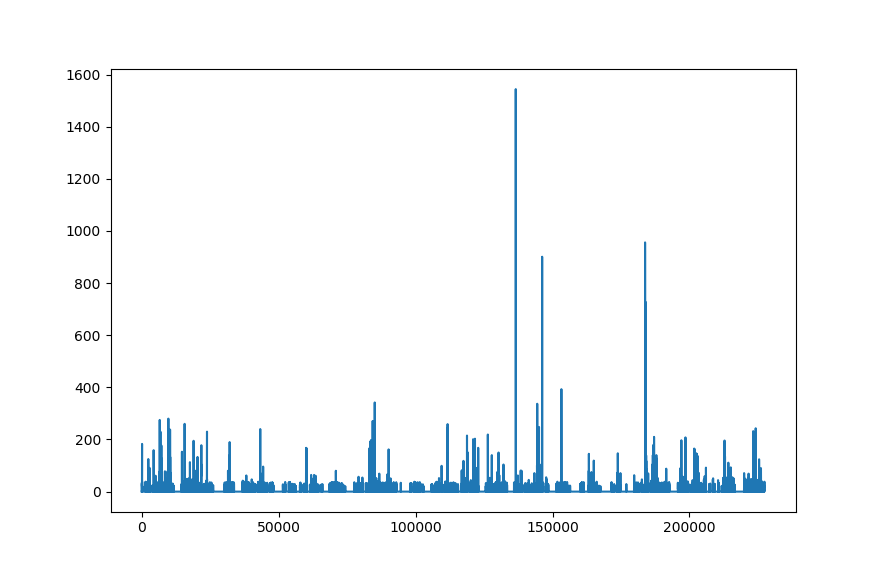

In [8]:
%matplotlib notebook
df['step_value'].plot()

In [10]:
dfstephour = pd.DataFrame({})
dfstephour = df[['week', 'weekday']].set_index(['week', 'weekday'])
dfstephour = dfstephour[~dfstephour.index.duplicated(keep='first')]
dfstephour.reset_index(inplace=True)
# this is where the data have null
dfadd = pd.DataFrame({'week' : [12], 'weekday':['5']})
dfstephour = dfstephour.append(dfadd, ignore_index=True)
dfadd = pd.DataFrame({'week' : [12], 'weekday':['2']})
dfstephour = dfstephour.append(dfadd, ignore_index=True)
dfadd = pd.DataFrame({'week' : [12], 'weekday':['1']})
dfstephour = dfstephour.append(dfadd, ignore_index=True)
dfadd = pd.DataFrame({'week' : [12], 'weekday':['0']})
dfstephour = dfstephour.append(dfadd, ignore_index=True)
dfstephour = dfstephour.set_index(['week', 'weekday'])
dfstephour.sort_index(inplace=True)
for i in range(24):
    dfstephour[i] = 0

In [11]:
# here I map between integer and the sting it's mean
timeslidemap = {0:'msteps', 1:'asteps', 2:'esteps'}
basestamp = df['timestamp'][0]
endstamp = df['timestamp'][-1:].values[0]
# for num, row in df[:30000].iterrows():
while True:
    try:
        hour = datetime.datetime.fromtimestamp(basestamp).hour
        dfbetween = df.loc[df['timestamp'].between(
            datetime.datetime.fromtimestamp(basestamp).replace(hour=hour,minute=0,second=0).timestamp(),
            datetime.datetime.fromtimestamp(basestamp).replace(hour=hour,minute=59,second=59).timestamp()
                    , inclusive=True)]
        steps = dfbetween['step_value'].sum()
    #     print(int(datetime.datetime.fromtimestamp(basestamp).strftime('%m')),
    #             int(datetime.datetime.fromtimestamp(basestamp).strftime('%d')),
    #                 timeslidemap[estimedevide])
    
        dfstephour.loc[[(datetime.datetime.fromtimestamp(basestamp).isocalendar()[1] - 
                                    (datetime.datetime.fromtimestamp(basestamp).isoweekday() < 7),
                            datetime.datetime.fromtimestamp(basestamp).strftime('%w'))], 
                                           [hour]] += steps

        basestamp = (datetime.datetime.fromtimestamp(basestamp) + datetime.timedelta(hours=1)).timestamp()
        if basestamp > endstamp:
            break
    except Exception as e:
#         print(str(e))
        basestamp = (datetime.datetime.fromtimestamp(basestamp) + datetime.timedelta(hours=1)).timestamp()
#     else:
#         print(datetime.datetime.fromtimestamp(basestamp) ,datetime.datetime.fromtimestamp(endstamp))

In [12]:
dfstephour

0     1      2    3    4    5       6       7       8   \
week weekday                                                              
12   0          0.0   0.0    0.0  0.0  0.0  0.0     0.0     0.0     0.0   
     1          0.0   0.0    0.0  0.0  0.0  0.0     0.0     0.0     0.0   
     2          0.0   0.0    0.0  0.0  0.0  0.0     0.0     0.0     0.0   
     3          0.0   0.0    0.0  0.0  0.0  0.0     0.0     0.0     0.0   
     4          0.0   0.0    0.0  0.0  0.0  0.0     0.0     0.0     0.0   
     5          0.0   0.0    0.0  0.0  0.0  0.0     0.0     0.0     0.0   
     6          0.0   0.0    0.0  0.0  0.0  0.0     0.0     0.0     0.0   
13   0          0.0   0.0    0.0  0.0  0.0  0.0     0.0   320.0     0.0   
     1          0.0   0.0    0.0  0.0  0.0  0.0     0.0     0.0  2004.0   
     2          0.0   0.0    0.0  0.0  0.0  0.0     0.0   248.0   133.0   
     3          0.0   0.0    0.0  0.0  0.0  0.0     0.0     0.0   159.0   
     4          0.0   0.0    0.0  0.0  0.0  0.0   216.0   283.0    22.0   
     5          0.0   0.0    0.0  0.0  0.0  0.0     0.0   318.0   318.0   
     6          0.0   0.0    0.0  0.0  0.0  0.0     0.0     0.0   117.0   
14   0          0.0   0.0    0.0  0.0  0.0  0.0     0.0   692.0     0.0   
     1          0.0   0.0    0.0  0.0  0.0  0.0     0.0   289.0   568.0   
     2          0.0   0.0    0.0  0.0  0.0  0.0     0.0     0.0     0.0   
     3          0.0   0.0    0.0  0.0  0.0  0.0     0.0     0.0   327.0   
     4          0.0   0.0    0.0  0.0  0.0  0.0     0.0     0.0    34.0   
     5          0.0   0.0    0.0  0.0  0.0  0.0     0.0    91.0    61.0   
     6          0.0   0.0    0.0  0.0  0.0  0.0  1334.0    57.0     0.0   
15   0          0.0   0.0    0.0  0.0  0.0  0.0     0.0   229.0   770.0   
     1          0.0   0.0    0.0  0.0  0.0  0.0  1011.0   100.0  1935.0   
     2          0.0   0.0    0.0  0.0  0.0  0.0     0.0     0.0   389.0   
     3          0.0   0.0    0.0  0.0  0.0  0.0     0.0   298.0   503.0   
     4          0.0   0.0    0.0  0.0  0.0  0.0     0.0   342.0  1258.0   
     5          0.0   0.0    0.0  0.0  0.0  0.0     0.0   327.0  1418.0   
     6          0.0   0.0    0.0  0.0  0.0  0.0     0.0    53.0   732.0   
16   0          0.0   0.0    0.0  0.0  0.0  0.0     0.0   300.0  1206.0   
     1          0.0   0.0    0.0  0.0  0.0  0.0     0.0   503.0  2643.0   
     2          0.0   0.0    0.0  0.0  0.0  0.0     0.0     0.0     0.0   
     3          0.0  28.0    0.0  0.0  0.0  0.0     0.0     0.0   182.0   
     4          0.0   0.0    0.0  0.0  0.0  0.0     0.0     0.0     0.0   
     5          0.0   0.0    0.0  0.0  0.0  0.0     0.0   205.0     0.0   
     6          0.0   0.0    0.0  0.0  0.0  0.0     0.0    23.0   605.0   
17   0          0.0   0.0    0.0  0.0  0.0  0.0     0.0     0.0  1459.0   
     1          0.0   0.0    0.0  0.0  0.0  0.0     0.0     0.0     0.0   
     2          0.0   0.0    0.0  0.0  0.0  0.0     0.0   255.0   853.0   
     3          0.0   0.0    0.0  0.0  0.0  0.0     0.0     0.0   694.0   
     4          0.0   0.0    0.0  0.0  0.0  0.0     0.0     0.0    23.0   
     5          0.0   0.0    0.0  0.0  0.0  0.0     0.0   636.0    44.0   
     6         54.0   0.0    0.0  0.0  0.0  0.0     0.0     0.0     0.0   
18   0          0.0   0.0    0.0  0.0  0.0  0.0     0.0  1259.0    29.0   
     1          0.0   0.0    0.0  0.0  0.0  0.0     0.0     0.0  2145.0   
     2          0.0   0.0    0.0  0.0  0.0  0.0     0.0     0.0  1082.0   
     3         21.0   0.0    0.0  0.0  0.0  0.0     0.0     0.0   749.0   
     4          0.0   0.0    0.0  0.0  0.0  0.0     0.0     0.0     0.0   
     5          0.0   0.0    0.0  0.0  0.0  0.0     0.0   277.0   494.0   
     6        132.0   0.0    0.0  0.0  0.0  0.0     0.0     0.0   387.0   
19   0         31.0   0.0    0.0  0.0  0.0  0.0     0.0     0.0     0.0   
     1         72.0   0.0    0.0  0.0  0.0  0.0     0.0   182.0  2724.0   
     2          0.0   0.0    0.0  0.0  0.0

<IPython.core.display.Javascript object>


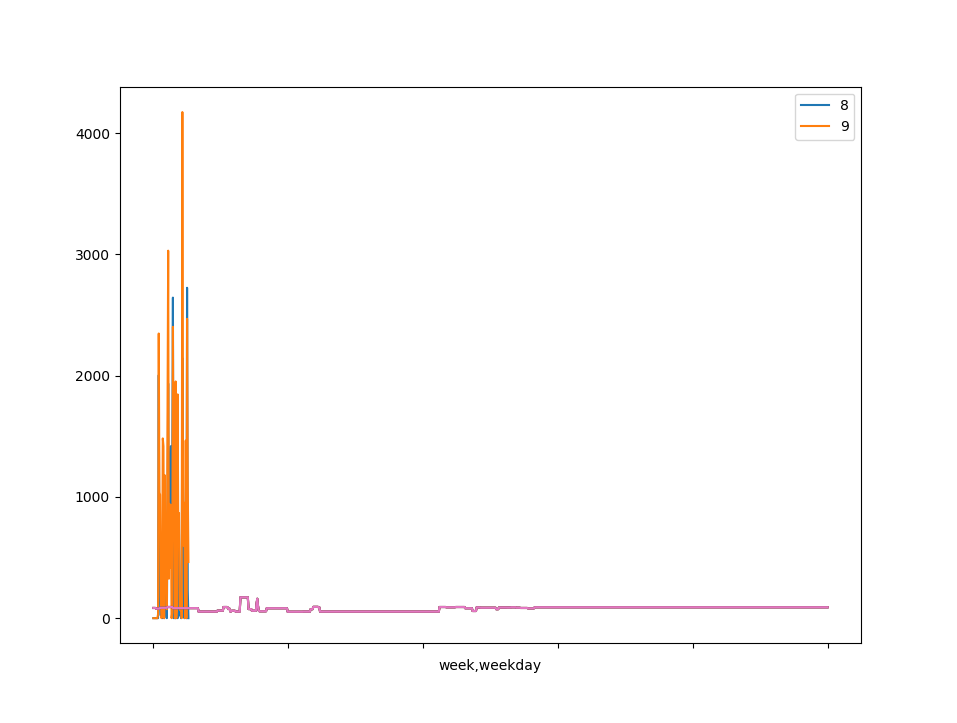

In [21]:
dfstephour[[8,9]].plot()

In [78]:
test = dfstephour.reset_index()

In [79]:
# plt.xticks()
test['weekday'] = test['weekday'].astype(int)
test = test.set_index(['week','weekday'])
# test

# test.plot(kind='line',x='weekday',y=[8,9])

<IPython.core.display.Javascript object>


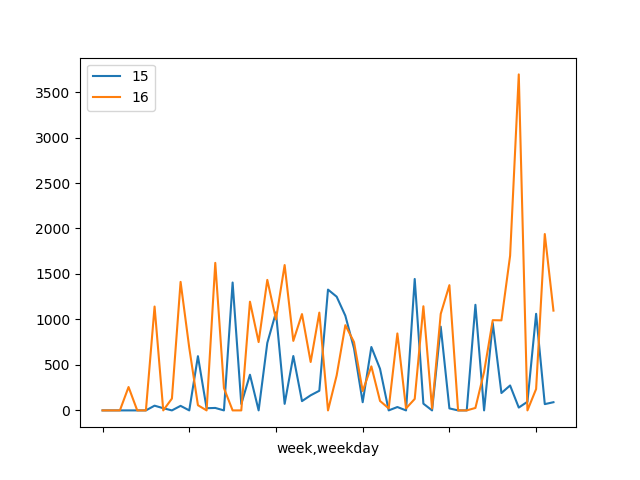

In [90]:
test[[15,16]].plot()

<IPython.core.display.Javascript object>


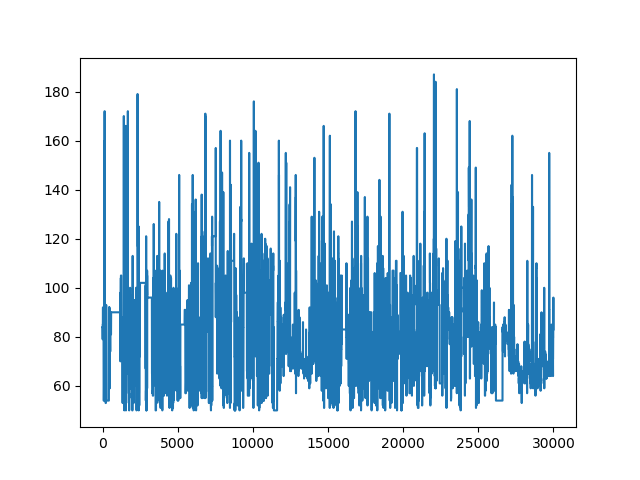

In [98]:
plt.figure()
df['hr_value'][0:30000].plot()
plt.show()